Camera Calibration with OpenCV
===

### Code Cell 1 - Used to calculate object points and extract image points for camera calibration using images in /camera_cal. 

It also calculates a measure of the total error


In [82]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    imagename = fname.split('\\')[-1]
    imagename_root, imagename_ext = imagename.split('.')
    img = cv2.imread(fname)


    
    # found that blue channel gave better results than grayscale,red,green,or h,s,v
    blue,g,r = cv2.split(img)
    
    # ran some experiments on manually thresholding
    #get a grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray_eq = cv2.equalizeHist(gray)
    #cv2.threshold(gray_eq, threshold, Max_val, type) type - THRESH_BINARY
    #res, gray_threshold = cv2.threshold(gray_eq, 60, 255, cv2.THRESH_BINARY)

    intersections = (9,6)

    '''
    values for Flags in findChessboardCorners - could not locate these flags in the python library - 
        { 
          cv::CALIB_CB_ADAPTIVE_THRESH = 1, 
          cv::CALIB_CB_NORMALIZE_IMAGE = 2, 
          cv::CALIB_CB_FILTER_QUADS = 4, 
          cv::CALIB_CB_FAST_CHECK = 8 
        }
    '''
    ret, corners = cv2.findChessboardCorners(blue, intersections, 1+2)
    chessboard = blue
        
# try using individual BGR channels instead
    if ret != True:  
        ret, corners = cv2.findChessboardCorners(g, intersections, 1+2)
        if ret != True:  
            ret, corners = cv2.findChessboardCorners(r, intersections, 1+2)
            if ret == True:
                print("found corners with R channel on image {}".format(imagename_root))
                chessboard = r
            else:
                chessboard = blue # best bet
        else:
            print("found corners with G channel on image {}".format(imagename_root))
            chessboard = g

    #    while ret
    #    ret, corners = cv2.findChessboardCorners(r, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        
        #subpixel location (probably not that much use for our case)
        corners2 = cv2.cornerSubPix(chessboard, corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, intersections, corners2, ret)
        write_name = './output_images/corners_found'+str(imagename_root)+'.png'
        cv2.imwrite(write_name, img)
#        cv2.imshow('img', img)
#        cv2.waitKey(500)
    else:
        print("No result for idx:{} fname: {}".format(idx, imagename))
        #try good features to track to see what is showing up
        cornersF = cv2.goodFeaturesToTrack(chessboard,54+10,0.01,10)
        cornersF = np.int0(cornersF)
        for i in cornersF:
            x,y = i.ravel()
            cv2.circle(img,(x,y),3,255,-1)
        cv2.imshow('FeaturestoTrack',img)
        cv2.waitKey(500)
        cv2.imwrite('./output_images/notfound'+str(imagename_root)+'.png',img);
        cv2.destroyAllWindows()

# Do camera calibration given object points and image points
img_size = (img.shape[1],img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#lets see what the error is 
tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error
print("total error: {}".format(tot_error/len(objpoints)))

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/cal_dist_pickle.p", "wb" ) )


No result for idx:0 fname: calibration1.jpg
No result for idx:15 fname: calibration5.jpg
total error: 0.1109489333060773


### Code Cell 2 - corners_unwarp - function to correct chessboard images for camera distortion and perspective distortion, and to plot at center of image

This function also brings up the images of chessboard images where it can't find the corners after the camera distortion correction, and shows corners that it can find - possibly identifying reasons why it can't find others.

In [83]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def corners_unwarp(img, nx, ny, in_mtx, in_dist, imagename):  
    # Use the OpenCV undistort() function to remove distortion
    new_mtx = in_mtx
    h,  w = img.shape[:2]
    new_mtx, roi=cv2.getOptimalNewCameraMatrix(in_mtx,in_dist,(w,h),1,(w,h))
    undist = cv2.undistort(img, in_mtx, in_dist, None, new_mtx)
    cv2.imwrite('./output_images/undistorted'+str(imagename)+'.png',undist)
    
    h,  w = undist.shape[:2]
    img_size = (w, h)
            
    # generate the desired board shape in output based on known dimensions
    offset_x = int(w/4) #1280/4 = 320
    offset_y = int(h/4) #720/4 = 180
    int_board_x = int(w * 0.4)
    int_board_y = int(w * 0.4 * 5 / 8)
    dst = np.float32([[offset_x, offset_y],
                          [offset_x+int_board_x, offset_y], 
                          [offset_x + int_board_x, offset_y + int_board_y], 
                          [offset_x, offset_y + int_board_y]])
       
       
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

    # Search for corners in the image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), 1+2+4)
    if ret != True:  
        # try switching to blue channel
        gray_in,g,r = cv2.split(img)
        gray = cv2.undistort(gray_in, in_mtx, in_dist, None, new_mtx)
        ret, corners = cv2.findChessboardCorners(gray, intersections, 1+2+4)

    if ret == True:
        corners = cv2.cornerSubPix(gray, corners,(11,11),(-1,-1),criteria)
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)      
        # grab the outer four detected corners as source locations
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
      
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
        warped = np.copy(warped)
    else:
        print("corners Not found on img {}".format(imagename))
        cornersF = cv2.goodFeaturesToTrack(gray,64,0.01,10)
        cornersF = np.int0(cornersF)
        for i in cornersF:
            x,y = i.ravel()
            cv2.circle(undist,(x,y),3,255,-1)
        cv2.imshow('FeaturestoTrack',undist)
        cv2.waitKey(5000)
        cv2.imwrite('./output_images/unwarped_nocorners'+str(imagename)+'.png',gray);
        warped = np.array([0])
    
    # Return the resulting image and matrix
    cv2.destroyAllWindows()
    return ret, warped #, M

### Code Cell 3 - tests use of corners_unwarp function on the chessboard images using camera distortion values generated in the first code cell.  The results are plotted up and saved to the output_images folder 

corners Not found on img calibration1
Unsuccesful on image ./camera_cal\calibration1.jpg try 8*5 instead
corners Not found on img calibration1
No luck...
corners Not found on img calibration2
Unsuccesful on image ./camera_cal\calibration2.jpg try 8*5 instead
corners Not found on img calibration2
No luck...
corners Not found on img calibration4
Unsuccesful on image ./camera_cal\calibration4.jpg try 8*5 instead
corners Not found on img calibration4
No luck...
corners Not found on img calibration5
Unsuccesful on image ./camera_cal\calibration5.jpg try 8*5 instead
corners Not found on img calibration5
No luck...


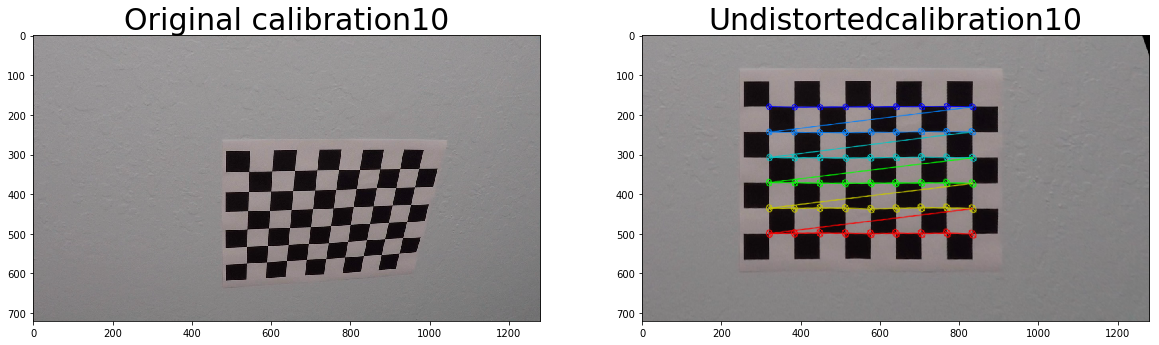

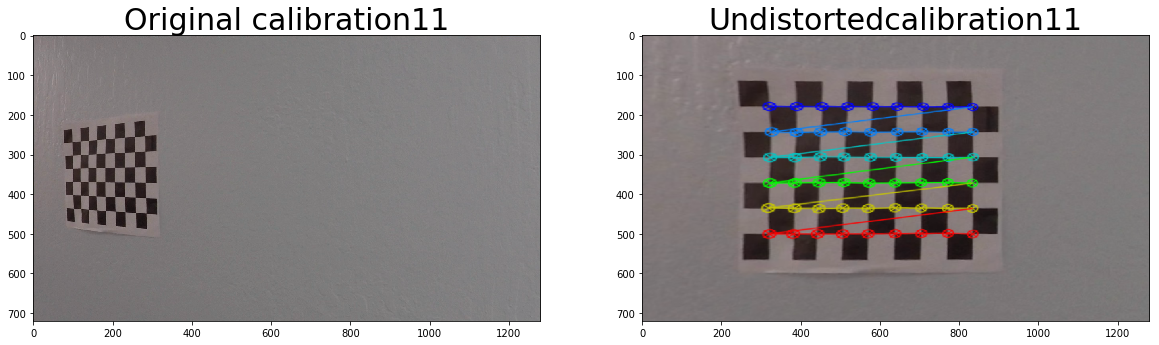

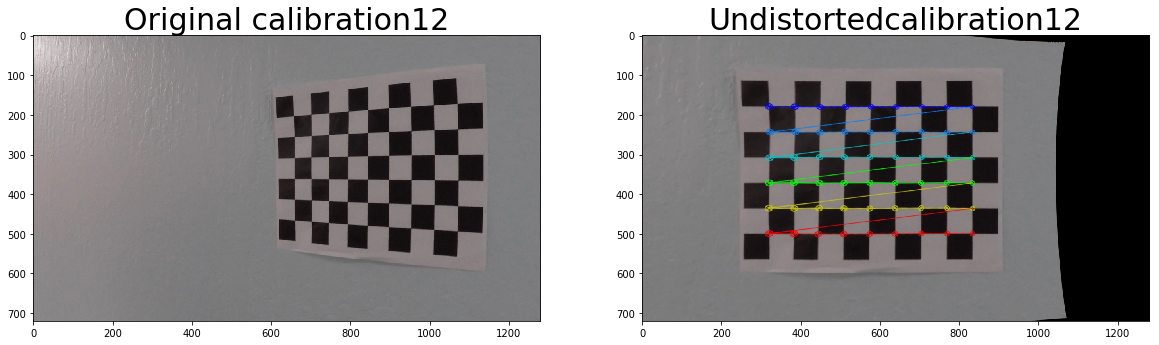

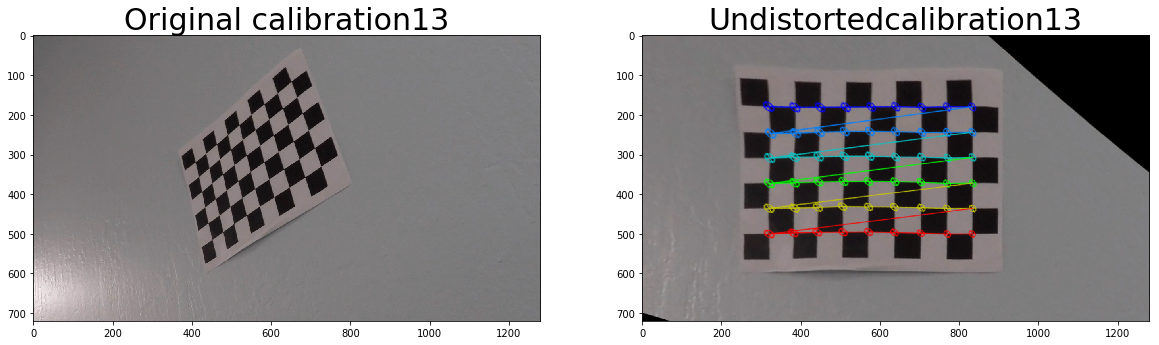

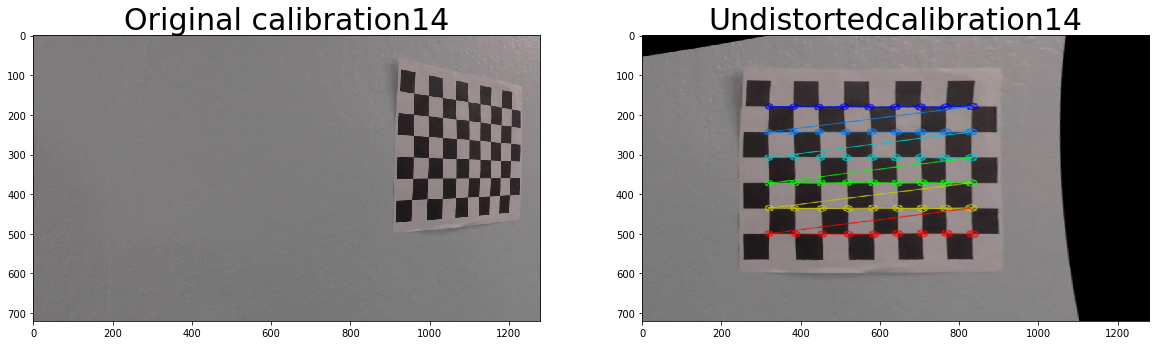

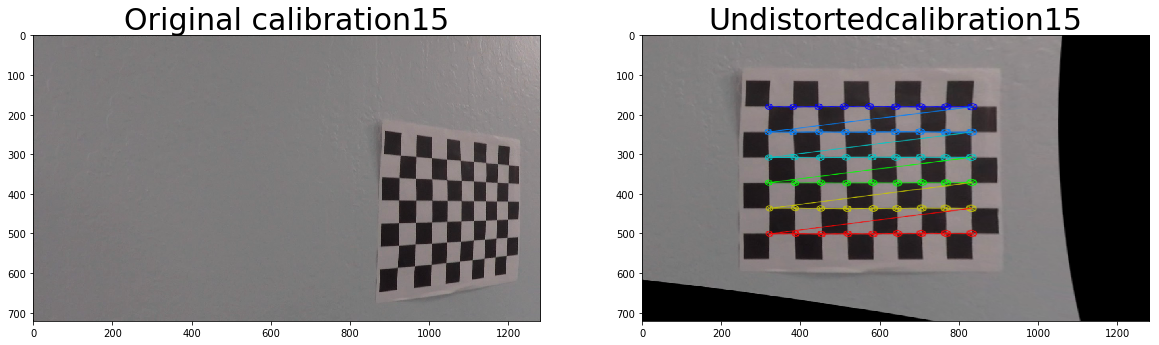

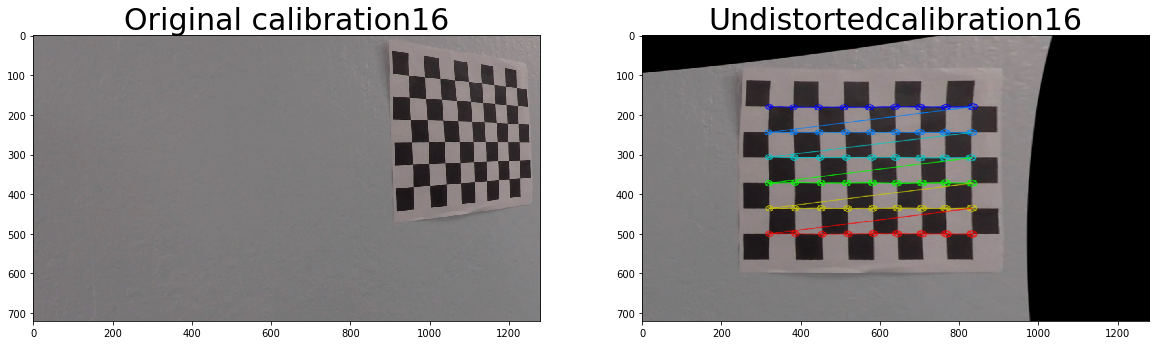

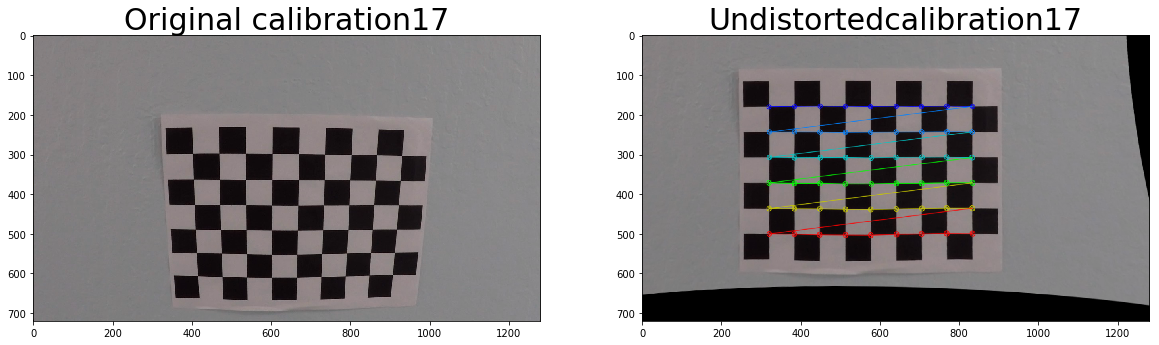

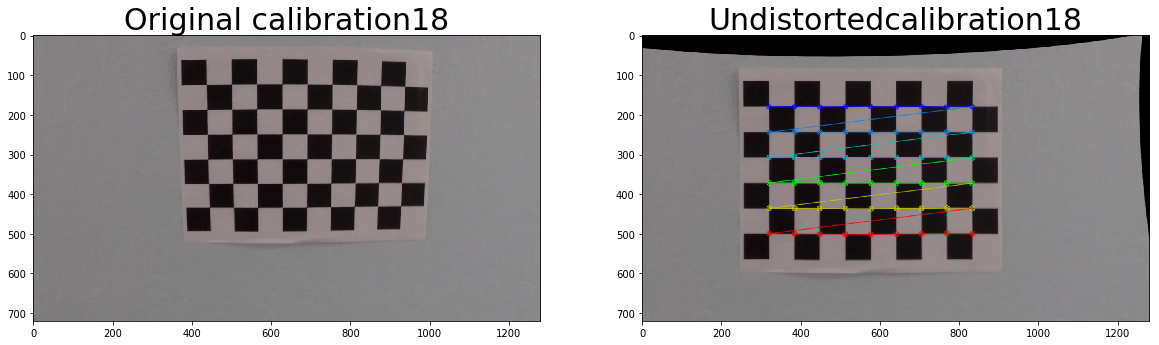

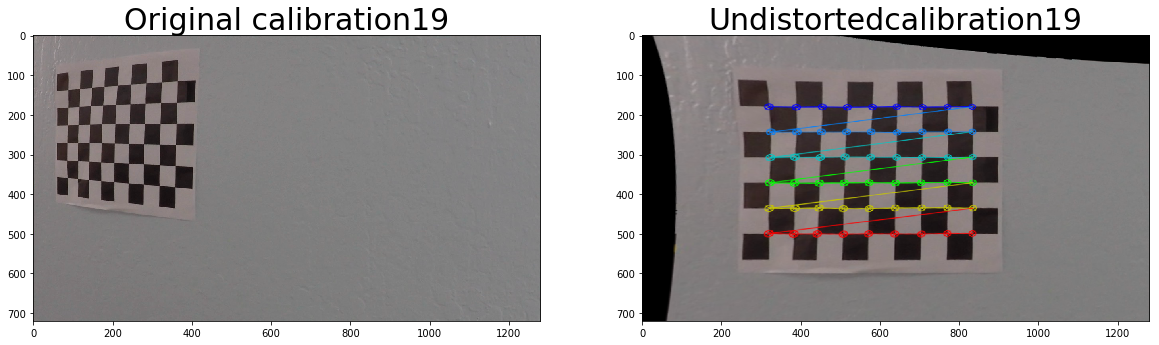

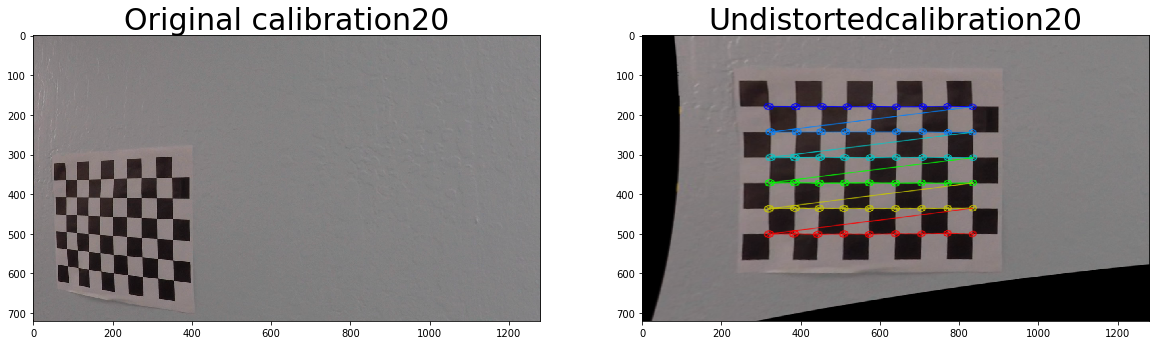

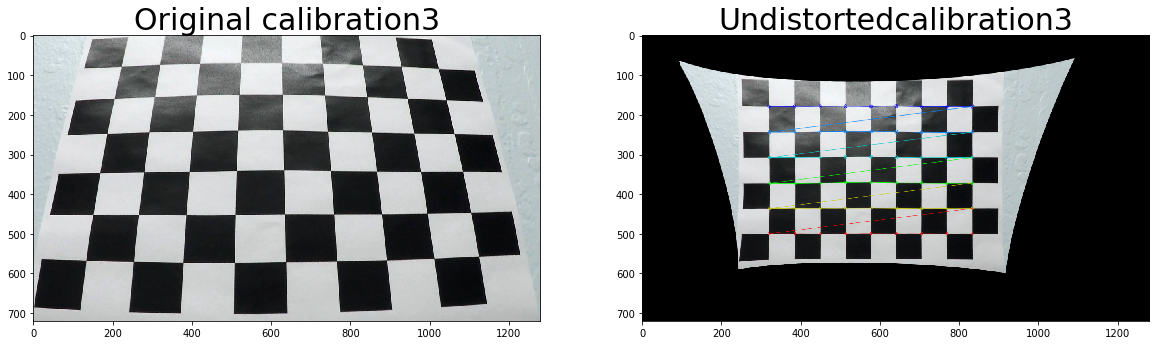

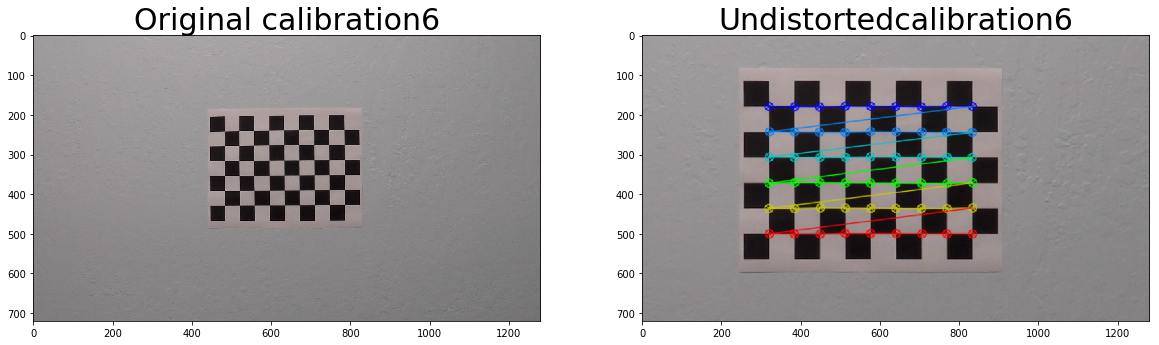

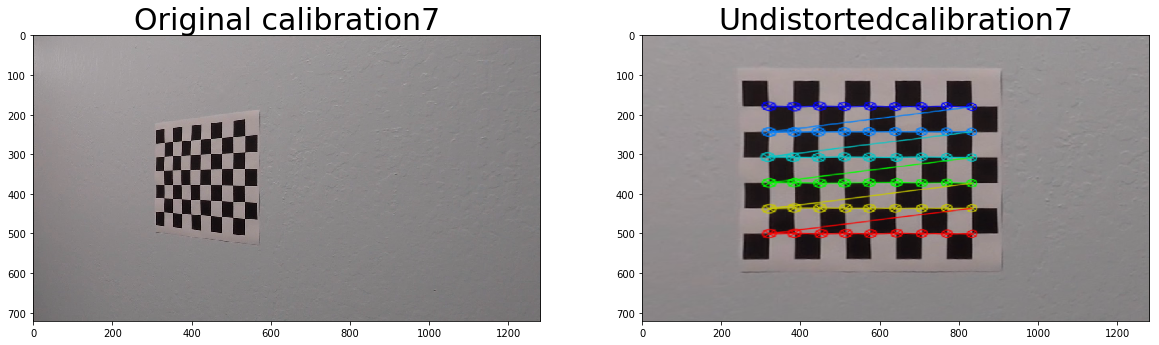

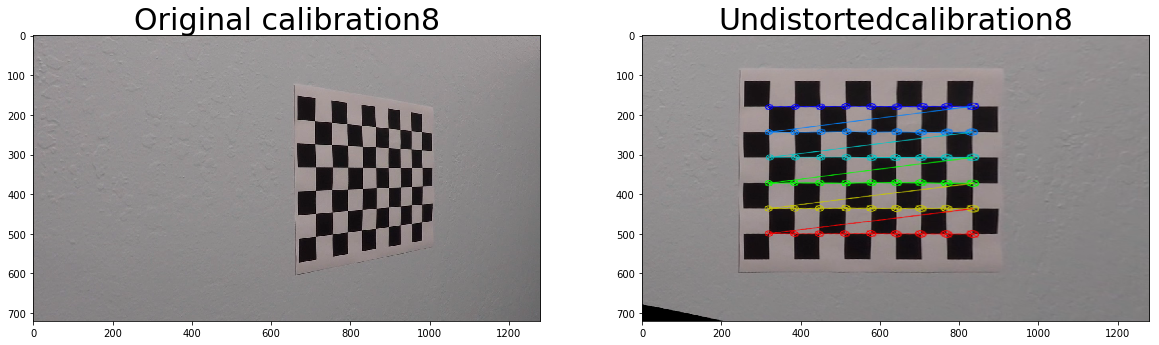

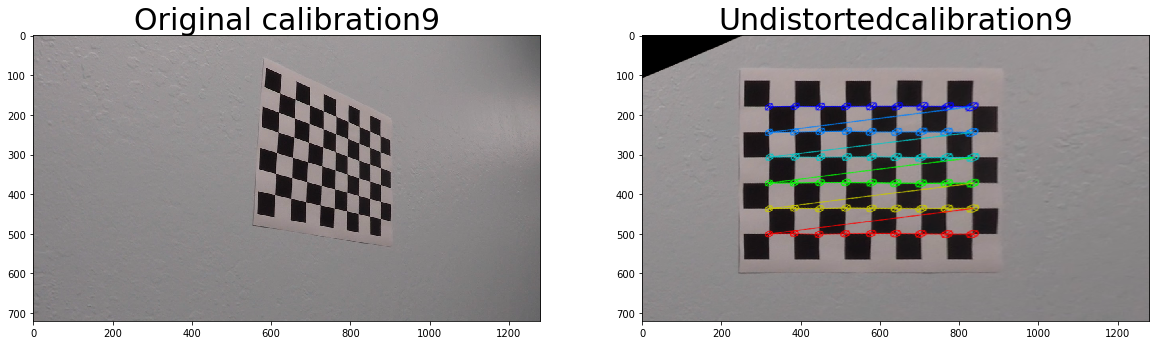

In [84]:
import pickle
%matplotlib inline

dist_pickle = pickle.load( open( "./camera_cal/cal_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


def plot_undist(warped_img,unwarped_img,img_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(warped_img)
    ax1.set_title('Original ' +  img_name, fontsize=30)
    ax2.imshow(unwarped_img)
    ax2.set_title('Undistorted' + img_name, fontsize=30);

# Test undistortion on an image
for idx, fname in enumerate(images):
    imagename = fname.split('\\')[-1]
    imagename_root, imagename_ext = imagename.split('.')
    #print("idx: {}, fname: {}".format(idx, imagename_root))
    img = cv2.imread(fname)
    #plot_undist(img, img)
    ret, img_unwarped = corners_unwarp(img, 9, 6, mtx, dist, imagename_root)
    if ret == True:
        plot_undist(img, img_unwarped, imagename_root)
        cv2.imwrite('./output_images/warped'+str(imagename_root)+'.png',img_unwarped);
    else:
        print("Unsuccesful on image {} try 8*5 instead".format(fname))
        ret, img_unwarped = corners_unwarp(img, 8, 5, mtx, dist, imagename_root)
        if ret == True:
            plot_undist(img, img_unwarped, imagename_root)
            cv2.imwrite('./output_images/warped'+str(imagename_root)+'.png',img_unwarped);
        else:
            print("No luck...")
            

### Results of Chessboard Image Distortion Correction
Thye image correction generally worked well and plotted up the chessboard images so the squares were square and lines were linear, and it looked like the image was taken dead on.

I could not get the chessboard corner detector to work on four images 1, 2, 4, 5 after the camera distortion was fixed.
Two of the images (1 and 5) did not have all corners within the image, so this was expected.
In the other two (2 and 4), the corners were detected before the camera distortion fix was applied, but the function could not find the corners after the fix.  I attempted to use the blue channel again, but this did not help.